<a href="https://colab.research.google.com/github/AnastasiiaVoll/-Geopolitics-of-Renewable-Energy-time-varying-interactions-between-geopolitical-risk-and-renewable/blob/main/Copy_of_Data_Analysis_and_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: Uploading and Cleaning the Data

1.1. Uploading the Data

In [ ]:
pip install fancyimpute

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install researchpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the necessary libraries
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import graphviz
import pickle
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.experimental import enable_iterative_imputer

# Sklearn libraries for preprocessing and model selection
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# Sklearn libraries for metrics
from sklearn.metrics import (confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, 
                             accuracy_score, precision_score, recall_score, f1_score, classification_report)

# Sklearn libraries for models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
from sklearn.impute import KNNImputer
from imblearn.under_sampling import RandomUnderSampler

# Keras libraries for neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Imbalance libraries for oversampling
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Special import for category encoders
import category_encoders as ce

# G Drive mount 
from google.colab import drive

In [ ]:
# Connected to my Googel drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the path to your files
path = '/content/drive/MyDrive/ML& Analysis data'  # replace with your path

# Create a list of all csv file names
all_filenames = [i for i in glob.glob(path + '/*.csv')]

# Read and concatenate datasets
data = pd.concat([pd.read_csv(f) for f in all_filenames])

In [ ]:
# Sample 5% of my data
data = data.sample(frac=0.05)

In [ ]:
# A couple of vars I will not be using in any case, such as the record number of 
# an individul (as it is pseudo panel, so IDs are non repeating), etc., so I am droping them
# Additioanlly, as meantioned in the report, I restrict the dataset variable range only to those variables that are readily avaliable on the close to real-time basis for the givernments on average
vars_to_drop = ['REC_NUM', 'CMA', 'AGE_6', 'MJH', 'FTPTLAST', 'COWMAIN', 'NAICS_21', 'NOC_10', 'NOC_40', 'YABSENT', 
                'WKSAWAY', 'PAYAWAY', 'UHRSMAIN', 'AHRSMAIN', 'FTPTMAIN', 'UTOTHRS', 'ATOTHRS', 'HRSAWAY', 'YAWAY', 
                'PAIDOT', 'UNPAIDOT', 'XTRAHRS', 'WHYPT', 'TENURE', 'PREVTEN', 'HRLYEARN', 'PERMTEMP', 'ESTSIZE', 
                'FIRMSIZE', 'AVAILABL', 'LKPUBAG', 'LKEMPLOY', 'LKRELS', 'LKATADS', 'LKANSADS', 'LKOTHERN', 'YNOLOOK', 
                'TLOLOOK', 'EFAMTYPE', 'FINALWT']

data = data.drop(vars_to_drop, axis=1)


In [ ]:
# LFSSTAT, the primary var of interest, is the Labour force status, categorical var 
# that has values:
# 1	= Employed (at work),  
# 2	= Employed (absent from work), 
# 3 =	Unemployed, 4 =	Not in labour force
# I am interested in predicting the employed status, so I modify it into a binary var

# Function to apply
def modify_values(val):
    if val == 1:
        return 1
    if val == 2:
        return 1        
    else:
        return 0

# Applying this function to the LFSSTAT var
data['LFSSTAT'] = data['LFSSTAT'].apply(modify_values)

In [ ]:
# First 5 rows of the data to eyebol 
print(data.head())

         SURVYEAR  SURVMNTH  LFSSTAT  PROV  AGE_12  SEX  MARSTAT  EDUC  \
1292753      2018         1        1    59       4    2        1     3   
3590225      2020         3        1    24       3    2        2     5   
331800       2017         4        0    10      12    1        1     0   
1500630      2018         3        1    24       8    2        2     4   
2114410      2018         9        0    48      12    2        1     5   

         EVERWORK  IMMIG  UNION  DURUNEMP  FLOWUNEM  UNEMFTPT  WHYLEFTO  \
1292753       NaN      3    1.0       NaN       NaN       NaN       NaN   
3590225       NaN      3    1.0       NaN       NaN       NaN       NaN   
331800        2.0      3    NaN       NaN       NaN       NaN       NaN   
1500630       NaN      3    1.0       NaN       NaN       NaN       NaN   
2114410       2.0      3    NaN       NaN       NaN       NaN       NaN   

         WHYLEFTN  DURJLESS  PRIORACT  SCHOOLN  AGYOWNK  
1292753       NaN       NaN       NaN      1.0

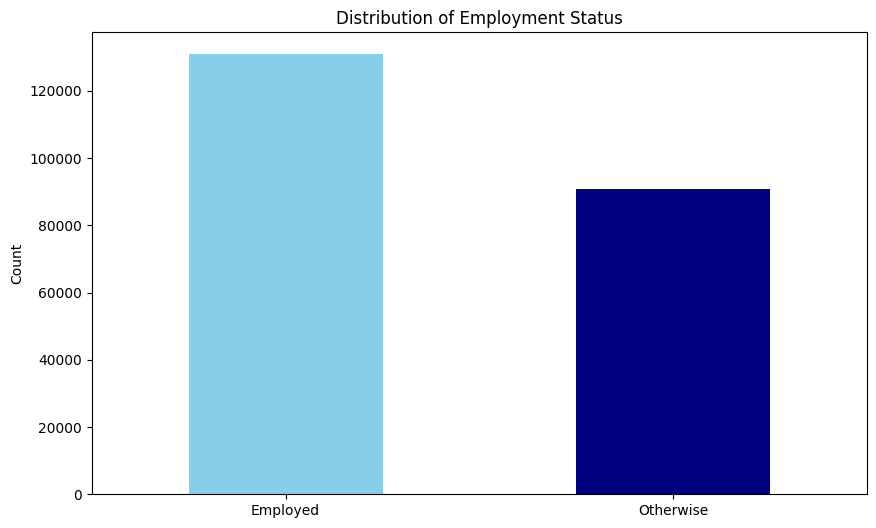

In [ ]:
# Bar plot
plt.figure(figsize=(10, 6))
data['LFSSTAT'].value_counts().plot(kind='bar', color=['skyblue', 'navy'])
plt.title('Distribution of Employment Status')
plt.xticks([0, 1], ['Employed', 'Otherwise'], rotation=0)
plt.ylabel('Count')
plt.show()

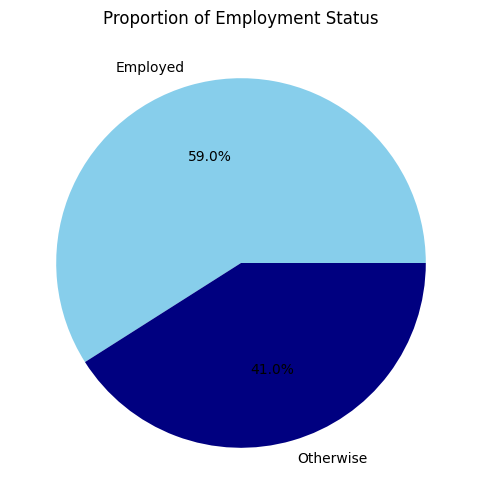

In [ ]:
# Pie chart
plt.figure(figsize=(10, 6))
data['LFSSTAT'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['Employed', 'Otherwise'], colors=['skyblue', 'navy'])
plt.title('Proportion of Employment Status')
plt.ylabel('') 
plt.show()

1.2. Dealing with Missing Data

In [ ]:
# Unfortunately, a number of the models that I plan to utilize are not capable of
# handling missing data. Most of them really. As a result, it's crucial to completely handle missing 
# data before proceeding. 

# Checking for missing values
print("Missing values:")
print(data.isnull().sum())

Missing values:
SURVYEAR         0
SURVMNTH         0
LFSSTAT          0
PROV             0
AGE_12           0
SEX              0
MARSTAT          0
EDUC             0
EVERWORK    130868
IMMIG            0
UNION       110845
DURUNEMP    212665
FLOWUNEM    212214
UNEMFTPT    212214
WHYLEFTO    204318
WHYLEFTN    204318
DURJLESS    143553
PRIORACT    213647
SCHOOLN      50245
AGYOWNK     161927
dtype: int64


In [ ]:
# Checking for missing values, percentage wise 
print("Missing values in percentage:")
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

# As a rough guideline, if a variable has more than 50% to 70% missing values, 
# I consider dropping the variable since the majority of the data is missing. 
# Imputing such a large proportion might lead to highly biased results.

# I decided on a 75% threshold, which is somewhat arbitrary, of course. A better 
# approach would indeed be to try out different thresholds together with multiple 
# ways of imputing the missing data. However, the amount of computational power 
# and time needed for that given the immence size of my dataset goes beyond this assignment.


Missing values in percentage:
SURVYEAR     0.000000
SURVMNTH     0.000000
LFSSTAT      0.000000
PROV         0.000000
AGE_12       0.000000
SEX          0.000000
MARSTAT      0.000000
EDUC         0.000000
EVERWORK    59.005099
IMMIG        0.000000
UNION       49.977231
DURUNEMP    95.885315
FLOWUNEM    95.681971
UNEMFTPT    95.681971
WHYLEFTO    92.121862
WHYLEFTN    92.121862
DURJLESS    64.724448
PRIORACT    96.328075
SCHOOLN     22.654210
AGYOWNK     73.008824
dtype: float64


In [ ]:
# Threshold
threshold = 0.75

# Identifying columns to drop
cols_to_drop = data.columns[data.isnull().mean() > threshold]

# Droping identified columns
data = data.drop(cols_to_drop, axis=1)

In [ ]:
# Checking for missing values, percentage wise 
print("Missing values in percentage:")
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

Missing values in percentage:
SURVYEAR     0.000000
SURVMNTH     0.000000
LFSSTAT      0.000000
PROV         0.000000
AGE_12       0.000000
SEX          0.000000
MARSTAT      0.000000
EDUC         0.000000
EVERWORK    59.005099
IMMIG        0.000000
UNION       49.977231
DURJLESS    64.724448
SCHOOLN     22.654210
AGYOWNK     73.008824
dtype: float64


In [ ]:
# I've managed to significantly reduce the missing data in the dataset, although 
# at the expense of discarding some potentially valuable information. 

# At this point, I need to determine how to manage rows (individuals) that still 
# have missing data. There are primarily two strategies I can consider:
# 1. Deleting: I can eliminate rows that have any missing data. The advantage of 
# this method is its simplicity and the fact that it doesn't introduce additional 
# bias through assumptions. However, the downside is that I might lose important 
# information, especially if the missing data is not completely at random. If the 
# data is missing in a systematic way, eliminating these rows could introduce bias.
# 2. Imputing: Alternatively, I can impute missing data, which means I estimate 
# and fill in the missing values based on the information I have. There are several
# methods to do this, such as mean/median imputation, regression imputation, or 
# using machine learning models like k-Nearest Neighbors or multiple imputations
# by chained equations (MICE). The advantage is that I keep the data and avoid 
# losing information. However, the downside is that I introduce some level of 
# assumption into the dataset, which might lead to misrepresentation if my imputation
# strategy does not reflect the true nature of the data.

# Before deciding on my steps, I look into the state of missing values in the data
missing_rows = data.isnull().any(axis=1).sum()
total_rows = data.shape[0]
percentage_missing = (missing_rows / total_rows) * 100

print(f"Number of rows with at least one missing value: {missing_rows}")
print(f"Percentage of rows with at least one missing value: {percentage_missing}%")

for i in [3, 5, 10, 15, 20, 25]:
    missing_rows_i = data[data.isnull().sum(axis=1) > i].shape[0]
    percentage_missing_i = (missing_rows_i / total_rows) * 100
    print(f"Number of rows with more than {i} missing values: {missing_rows_i}")
    print(f"Percentage of rows with more than {i} missing values: {percentage_missing_i}%")

# Given that I have approximately 100% of individuals in the dataset with at least
# one missing value, simply deleting the rows with missing values would not be possible


Number of rows with at least one missing value: 221791
Percentage of rows with at least one missing value: 100.0%
Number of rows with more than 3 missing values: 18784
Percentage of rows with more than 3 missing values: 8.469234549643584%
Number of rows with more than 5 missing values: 0
Percentage of rows with more than 5 missing values: 0.0%
Number of rows with more than 10 missing values: 0
Percentage of rows with more than 10 missing values: 0.0%
Number of rows with more than 15 missing values: 0
Percentage of rows with more than 15 missing values: 0.0%
Number of rows with more than 20 missing values: 0
Percentage of rows with more than 20 missing values: 0.0%
Number of rows with more than 25 missing values: 0
Percentage of rows with more than 25 missing values: 0.0%


In [ ]:
# While writing code for imputing, I will need to take into account a type of the data I am dealing with. 
#Checking the data types
print(data.dtypes)

# No all of them are correct, more should be int instead of float, but I cannot convert a var into
# int if it has missing data. So first I need to deal with it. 

# I plant to deal with the missing data using several approaches: 
# Please add shortly beneforts and minisuses of all approaches ....
# -> Mean / Most Freaquent missing data imputation (# Dataset 1, imputing using SimpleImputer)
# -> MICE missing data imputation (# Dataset 2, imputing using IterativeImputer (MICE))
# -> KNN missing data imputation (# Dataset 3, imputing using KNNImputer (KNN))

SURVYEAR      int64
SURVMNTH      int64
LFSSTAT       int64
PROV          int64
AGE_12        int64
SEX           int64
MARSTAT       int64
EDUC          int64
EVERWORK    float64
IMMIG         int64
UNION       float64
DURJLESS    float64
SCHOOLN     float64
AGYOWNK     float64
dtype: object


In [ ]:
# Function for converting data types
def convert_data_types(df, columns_int, columns_float):
    # Convert each column to integer and float data types respectively
    for column in columns_int:
        df[column] = df[column].astype(int)
    for column in columns_float:
        df[column] = df[column].astype(float)
    return df

columns_to_convert_int = ['SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC',  'EVERWORK', 'IMMIG', 'UNION', 'SCHOOLN', 'AGYOWNK']
columns_to_convert_float = ['DURJLESS']

In [ ]:
# Dataset 1, imputing using SimpleImputer
data_mean = data.copy()

# Here I do need to take into account the different types of data
# Why? As the cmissing ontinous vars will be imputed using the mean, but that would be
# a wrong approach to apply to the cathegorical vars. For the cathegorical vars I 
# impute them using most frequent value 
# Listing of columns to be imputed with mean
mean_columns = ['DURJLESS']
# Listting of columns to be imputed with most frequent value
freq_columns = ['SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC',  'EVERWORK', 'IMMIG', 'UNION', 'SCHOOLN', 'AGYOWNK']

# Imputation
imputer_mean = SimpleImputer(strategy='mean')
imputer_freq = SimpleImputer(strategy='most_frequent')

data_mean[mean_columns] = imputer_mean.fit_transform(data_mean[mean_columns])
data_mean[freq_columns] = imputer_freq.fit_transform(data_mean[freq_columns])

# Mean/Median/Mode Imputation: This is a simple technique where the missing values
# of a certain variable are filled in with its mean, median, or mode. While this 
# method is very easy to implement, it has the downside of potentially leading to 
# biased estimates, especially if the data isn't missing completely at random.

# Concatenating the year and month variables into a string, then convert to datetime
data_mean['Date'] = pd.to_datetime(data_mean['SURVYEAR'].astype(str) + '-' + data_mean['SURVMNTH'].astype(int).astype(str), format='%Y-%m')
data_mean = data_mean.drop(columns=['SURVYEAR']) # Survey year

# Converting each column to integer or float data type
data_mean = convert_data_types(data_mean, columns_to_convert_int, columns_to_convert_float)
print(data_mean.dtypes)

SURVMNTH             int64
LFSSTAT              int64
PROV                 int64
AGE_12               int64
SEX                  int64
MARSTAT              int64
EDUC                 int64
EVERWORK             int64
IMMIG                int64
UNION                int64
DURJLESS           float64
SCHOOLN              int64
AGYOWNK              int64
Date        datetime64[ns]
dtype: object


In [ ]:
pickle.dump(data_mean, open('/content/drive/MyDrive/ML& Analysis data/data_mean.pkl', 'wb'))

In [ ]:
# data_mean = pickle.load(open('/content/drive/MyDrive/ML& Analysis data/data_mean.pkl', 'rb'))

In [ ]:
print(data.head())

         SURVYEAR  SURVMNTH  LFSSTAT  PROV  AGE_12  SEX  MARSTAT  EDUC  \
1292753      2018         1        1    59       4    2        1     3   
3590225      2020         3        1    24       3    2        2     5   
331800       2017         4        0    10      12    1        1     0   
1500630      2018         3        1    24       8    2        2     4   
2114410      2018         9        0    48      12    2        1     5   

         EVERWORK  IMMIG  UNION  DURJLESS  SCHOOLN  AGYOWNK  
1292753       NaN      3    1.0       NaN      1.0      NaN  
3590225       NaN      3    1.0       NaN      1.0      NaN  
331800        2.0      3    NaN     163.0      NaN      NaN  
1500630       NaN      3    1.0       NaN      1.0      NaN  
2114410       2.0      3    NaN     240.0      NaN      NaN  


In [ ]:
print(data_mean.head())

         SURVMNTH  LFSSTAT  PROV  AGE_12  SEX  MARSTAT  EDUC  EVERWORK  IMMIG  \
1292753         1        1    59       4    2        1     3         2      3   
3590225         3        1    24       3    2        2     5         2      3   
331800          4        0    10      12    1        1     0         2      3   
1500630         3        1    24       8    2        2     4         2      3   
2114410         9        0    48      12    2        1     5         2      3   

         UNION    DURJLESS  SCHOOLN  AGYOWNK       Date  
1292753      1  102.046141        1        1 2018-01-01  
3590225      1  102.046141        1        1 2020-03-01  
331800       3  163.000000        1        1 2017-04-01  
1500630      1  102.046141        1        1 2018-03-01  
2114410      3  240.000000        1        1 2018-09-01  


In [ ]:
# Dataset 2, imputing using IterativeImputer (MICE)
data_mice = data.copy()

def perform_imputation(data, categorical_columns):
    """
    Imputes missing values using IterativeImputer.

    Parameters:
    - data: Dataframe with missing values
    - categorical_columns: List of categorical columns in the dataframe

    Returns:
    - Dataframe with imputed values
    """
    # Initializing an imputer
    imputer = IterativeImputer()

    # Performing imputation
    data_imputed = imputer.fit_transform(data)

    # Creating a new dataframe with the imputed data and original column names
    data_imputed = pd.DataFrame(data_imputed, columns=data.columns)

    # Rounding and cast to integers for categorical variables
    for col in categorical_columns:
        data_imputed[col] = np.round(data_imputed[col]).astype(int)

    return data_imputed

def convert_data_types(data_mice, columns_to_convert_int, columns_to_convert_float):
    """
    Converts specific columns in the dataframe to the desired data types.

    Parameters:
    - data_mice: The dataframe
    - columns_to_convert_int: List of columns to convert to integer data type
    - columns_to_convert_float: List of columns to convert to float data type

    Returns:
    - Dataframe with converted data types
    """
    # Converting each column to integer data type
    for column in columns_to_convert_int:
        data_mice[column] = data_mice[column].astype(int)

    # Converting each column to float data type
    for column in columns_to_convert_float:
        data_mice[column] = data_mice[column].astype(float)
        
    return data_mice

# Categorical columns
categorical_columns = ['SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC',  'EVERWORK', 'IMMIG', 'UNION', 'SCHOOLN', 'AGYOWNK']

# Performing imputation
data_mice = perform_imputation(data_mice, categorical_columns)

# Converting SURVYEAR to integer, then concatenate with SURVMNTH to create a Date column
data_mice['Date'] = pd.to_datetime(data_mice['SURVYEAR'].astype(int).astype(str) + '-' + data_mice['SURVMNTH'].astype(int).astype(str), format='%Y-%m')
data_mice = data_mice.drop(columns=['SURVYEAR']) # Survey year

# Converting data types
data_mice = convert_data_types(data_mice, columns_to_convert_int, columns_to_convert_float)

# Check 
print(data_mice.dtypes)


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


SURVMNTH             int64
LFSSTAT              int64
PROV                 int64
AGE_12               int64
SEX                  int64
MARSTAT              int64
EDUC                 int64
EVERWORK             int64
IMMIG                int64
UNION                int64
DURJLESS           float64
SCHOOLN              int64
AGYOWNK              int64
Date        datetime64[ns]
dtype: object


In [ ]:
# MICE imputed data summary
print("\nMICE Imputed Data:")
print(data_mice.describe())


MICE Imputed Data:
            SURVMNTH        LFSSTAT           PROV         AGE_12  \
count  221791.000000  221791.000000  221791.000000  221791.000000   
mean        6.747032       0.590051      35.263536       7.139523   
std         3.358717       0.491825      14.778054       3.526140   
min         1.000000       0.000000      10.000000       1.000000   
25%         4.000000       0.000000      24.000000       4.000000   
50%         7.000000       1.000000      35.000000       7.000000   
75%        10.000000       1.000000      47.000000      10.000000   
max        12.000000       1.000000      59.000000      12.000000   

                 SEX        MARSTAT           EDUC      EVERWORK  \
count  221791.000000  221791.000000  221791.000000  2.217910e+05   
mean        1.513321       2.823785       3.231443  1.174633e+12   
std         0.499824       2.149370       1.628411  9.790915e+11   
min         1.000000       1.000000       0.000000  1.000000e+00   
25%         1.0000

In [ ]:
print(data.describe())

            SURVYEAR       SURVMNTH        LFSSTAT           PROV  \
count  221791.000000  221791.000000  221791.000000  221791.000000   
mean     2018.409250       6.747032       0.590051      35.263536   
std         1.133354       3.358717       0.491825      14.778054   
min      2017.000000       1.000000       0.000000      10.000000   
25%      2017.000000       4.000000       0.000000      24.000000   
50%      2018.000000       7.000000       1.000000      35.000000   
75%      2019.000000      10.000000       1.000000      47.000000   
max      2020.000000      12.000000       1.000000      59.000000   

              AGE_12            SEX        MARSTAT           EDUC  \
count  221791.000000  221791.000000  221791.000000  221791.000000   
mean        7.139523       1.513321       2.823785       3.231443   
std         3.526140       0.499824       2.149370       1.628411   
min         1.000000       1.000000       1.000000       0.000000   
25%         4.000000       1.0000

In [ ]:
print(data_mean.describe())

            SURVMNTH        LFSSTAT           PROV         AGE_12  \
count  221791.000000  221791.000000  221791.000000  221791.000000   
mean        6.747032       0.590051      35.263536       7.139523   
std         3.358717       0.491825      14.778054       3.526140   
min         1.000000       0.000000      10.000000       1.000000   
25%         4.000000       0.000000      24.000000       4.000000   
50%         7.000000       1.000000      35.000000       7.000000   
75%        10.000000       1.000000      47.000000      10.000000   
max        12.000000       1.000000      59.000000      12.000000   

                 SEX        MARSTAT           EDUC       EVERWORK  \
count  221791.000000  221791.000000  221791.000000  221791.000000   
mean        1.513321       2.823785       3.231443       1.978412   
std         0.499824       2.149370       1.628411       0.368116   
min         1.000000       1.000000       0.000000       1.000000   
25%         1.000000       1.0000

In [ ]:
# Note the problem with the MICE imputer: 
# The IterativeImputer from sklearn uses a machine learning model (default is BayesianRidge) to predict missing values based on other variables. It does not inherently know that certain variables are categorical and should be within certain limits. As a result, it can sometimes generate predictions that do not fall into the expected categories.
# So I need to turn to a diffrent option. KNNImputer, inherently respect the bounds of the data because they base their imputations on observed values in the dataset.
# Before running the KNNImputer function, I need to normalize the data. Normalization is often a good practice before using distance-based algorithms like K-Nearest Neighbors (KNN). This is because KNN calculates the distance between pairs of data points to find the nearest neighbors; if one variable has a very large scale compared to others, it may dominate the distance calculations, leading to biased results.
# NOTE: this will take a long time to run. Preferdably do not repeat. I needed to leave the laptop working over night. 

# Dataset 3, imputing using KNNImputer (KNN)
# Create a mask for missing values
missing_mask = data.isnull().any(axis=1)

# Separate complete rows and rows with missing values
data_complete = data.loc[~missing_mask]
data_missing = data.loc[missing_mask]

# List of continuous and categorical columns
continuous_columns = ['DURJLESS']
categorical_columns = ['SURVYEAR', 'SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC', 'EVERWORK', 'IMMIG', 'UNION', 'SCHOOLN', 'AGYOWNK']

# Call the function to impute missing values using KNN
imputer = KNNImputer(n_neighbors=5)
data_missing_imputed = pd.DataFrame(imputer.fit_transform(data_missing), columns=data_missing.columns)

# Concatenate the complete rows and imputed rows
data_knn = pd.concat([data_complete, data_missing_imputed])

# Convert SURVYEAR to integer, then concatenate with SURVMNTH to create a Date column
data_knn['Date'] = pd.to_datetime(data_knn['SURVYEAR'].astype(int).astype(str) + '-' + data_knn['SURVMNTH'].astype(int).astype(str), format='%Y-%m')
data_knn = data_knn.drop(columns=['SURVYEAR']) # Survey year

# Convert data types
data_knn = convert_data_types(data_knn, columns_to_convert_int, columns_to_convert_float)

# Print the data types of the dataframe to confirm the changes
print(data_knn.dtypes)


SURVMNTH             int64
LFSSTAT              int64
PROV                 int64
AGE_12               int64
SEX                  int64
MARSTAT              int64
EDUC                 int64
EVERWORK             int64
IMMIG                int64
UNION                int64
DURJLESS           float64
SCHOOLN              int64
AGYOWNK              int64
Date        datetime64[ns]
dtype: object


In [ ]:
# Saving the dataset 
pickle.dump(data_knn, open('/content/drive/MyDrive/ML& Analysis data/data_knn.pkl', 'wb'))

In [ ]:
# data_knn = pickle.load(open('/content/drive/MyDrive/ML& Analysis data/data_knn.pkl', 'rb'))

In [ ]:
# Now I summarize and set up a dictionary for the datasets created for the later steps
def print_summary_statistics(data_dict):
    """
    Print summary statistics for each DataFrame in the input dictionary.
    
    Parameters:
    - data_dict: a dictionary where keys are descriptions and values are DataFrames
    
    """
    for description, df in data_dict.items():
        print(f"\n{description} Data:")
        print(df.describe())

# Create a dictionary to hold the datasets
data_dict = {
    "Original": data,
    "Mean Imputed": data_mean,
    "MICE Imputed": data_mice,
    "KNN Imputed": data_knn
}

# Print summary statistics for each dataset
print_summary_statistics(data_dict)

# KNN seems to perofrm quite reasonbley, I remove the MICE imputed data due to the previously mentioned problem with imputing the cathegorical vars, and will be using the KNN imputed data insted.
# Create a dictionary to hold the datasets
data_dict = {
    "Mean Imputed": data_mean,
    "KNN Imputed": data_knn
}


Original Data:
            SURVYEAR       SURVMNTH        LFSSTAT           PROV  \
count  221791.000000  221791.000000  221791.000000  221791.000000   
mean     2018.409250       6.747032       0.590051      35.263536   
std         1.133354       3.358717       0.491825      14.778054   
min      2017.000000       1.000000       0.000000      10.000000   
25%      2017.000000       4.000000       0.000000      24.000000   
50%      2018.000000       7.000000       1.000000      35.000000   
75%      2019.000000      10.000000       1.000000      47.000000   
max      2020.000000      12.000000       1.000000      59.000000   

              AGE_12            SEX        MARSTAT           EDUC  \
count  221791.000000  221791.000000  221791.000000  221791.000000   
mean        7.139523       1.513321       2.823785       3.231443   
std         3.526140       0.499824       2.149370       1.628411   
min         1.000000       1.000000       1.000000       0.000000   
25%         4.000

In [ ]:
data_dict = {
    "Mean Imputed": data_mean,
    "KNN Imputed": data_knn
}

In [ ]:
# Final check of missing values before procceding further
for dataset_name, dataset in data_dict.items():
    # Calculate missing values in percentage
    missing_percentage = (dataset.isnull().sum() / len(dataset)) * 100
    # Print the missing values percentage for each dataset
    print(f"\n{dataset_name} Data: Missing values in percentage")
    print(missing_percentage)


Mean Imputed Data: Missing values in percentage
SURVMNTH    0.0
LFSSTAT     0.0
PROV        0.0
AGE_12      0.0
SEX         0.0
MARSTAT     0.0
EDUC        0.0
EVERWORK    0.0
IMMIG       0.0
UNION       0.0
DURJLESS    0.0
SCHOOLN     0.0
AGYOWNK     0.0
Date        0.0
dtype: float64

KNN Imputed Data: Missing values in percentage
SURVMNTH    0.0
LFSSTAT     0.0
PROV        0.0
AGE_12      0.0
SEX         0.0
MARSTAT     0.0
EDUC        0.0
EVERWORK    0.0
IMMIG       0.0
UNION       0.0
DURJLESS    0.0
SCHOOLN     0.0
AGYOWNK     0.0
Date        0.0
dtype: float64


In [ ]:
# Checking the datasets details 
for dataset_name, dataset in data_dict.items():
    dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4436 entries, 276318 to 3254286
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   SURVMNTH  4436 non-null   int64         
 1   LFSSTAT   4436 non-null   int64         
 2   PROV      4436 non-null   int64         
 3   AGE_12    4436 non-null   int64         
 4   SEX       4436 non-null   int64         
 5   MARSTAT   4436 non-null   int64         
 6   EDUC      4436 non-null   int64         
 7   EVERWORK  4436 non-null   int64         
 8   IMMIG     4436 non-null   int64         
 9   UNION     4436 non-null   int64         
 10  DURJLESS  4436 non-null   float64       
 11  SCHOOLN   4436 non-null   int64         
 12  AGYOWNK   4436 non-null   int64         
 13  Date      4436 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(12)
memory usage: 519.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4436 entries, 0 to 4435
Dat

1.3. Merging the macro-economic data with the LFS datasets

In [ ]:
path = '/content/drive/MyDrive/ML& Analysis data/Canada_macro_data.xlsx' 

In [ ]:
# Load the Excel file
economic_indicators = pd.read_excel(path)

In [ ]:
print("Columns in economic_indicators: ", economic_indicators.columns)

for name, data in data_dict.items():
    print(f"Columns in {name}: ", data.columns)


Columns in economic_indicators:  Index(['Date', 'Growth rate same period previous year, s.a. Percentage',
       'Level, rate or national currency, s.a. Ratio',
       'Level, rate or national currency, s.a. Canadian Dollar, Millions'],
      dtype='object')
Columns in Mean Imputed:  Index(['SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC',
       'EVERWORK', 'IMMIG', 'UNION', 'DURJLESS', 'SCHOOLN', 'AGYOWNK', 'Date'],
      dtype='object')
Columns in KNN Imputed:  Index(['SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC',
       'EVERWORK', 'IMMIG', 'UNION', 'DURJLESS', 'SCHOOLN', 'AGYOWNK', 'Date'],
      dtype='object')


In [ ]:
# Confirm data type of 'Date' column
print("Data type of 'Date' in economic_indicators: ", economic_indicators['Date'].dtype)

for name, data in data_dict.items():
    print(f"Data type of 'Date' in {name}: ", data['Date'].dtype)
    
# Check uniqueness of 'Date' column
print("Is 'Date' unique in economic_indicators: ", economic_indicators['Date'].is_unique)

for name, data in data_dict.items():
    print(f"Is 'Date' unique in {name}: ", data['Date'].is_unique)


Data type of 'Date' in economic_indicators:  datetime64[ns]
Data type of 'Date' in Mean Imputed:  datetime64[ns]
Data type of 'Date' in KNN Imputed:  datetime64[ns]
Is 'Date' unique in economic_indicators:  True
Is 'Date' unique in Mean Imputed:  False
Is 'Date' unique in KNN Imputed:  False


In [ ]:
# Convert the 'Date' column to datetime format in 'economic_indicators' DataFrame
economic_indicators['Date'] = pd.to_datetime(economic_indicators['Date'])

# Make sure the 'Date' column in 'data_knn' DataFrame is also in datetime format
data_knn['Date'] = pd.to_datetime(data_knn['Date'])

# Merge the dataframes
data_knn = pd.merge(data_knn, economic_indicators, on='Date', how='left')

# Make sure the 'Date' column in 'data_knn' DataFrame is also in datetime format
data_mean['Date'] = pd.to_datetime(data_mean['Date'])

# Merge the dataframes
data_mean = pd.merge(data_mean, economic_indicators, on='Date', how='left')

In [ ]:
# Print the data types of the dataframe to confirm the changes
print(data_mean.dtypes)

SURVMNTH                                                                     int64
LFSSTAT                                                                      int64
PROV                                                                         int64
AGE_12                                                                       int64
SEX                                                                          int64
MARSTAT                                                                      int64
EDUC                                                                         int64
EVERWORK                                                                     int64
IMMIG                                                                        int64
UNION                                                                        int64
DURJLESS                                                                   float64
SCHOOLN                                                                      int64
AGYO

In [ ]:
# Describe dataset 0 
data.describe()

,SURVMNTH,LFSSTAT,PROV,AGE_12,SEX,MARSTAT,EDUC,EVERWORK,IMMIG,UNION,DURJLESS,SCHOOLN,AGYOWNK
count,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000
mean,6.780884,0.596032,35.301623,7.094004,1.508566,2.825293,3.245717,1.613616,2.756087,2.123986,70.211722,1.100541,2.156673
std,3.342630,0.490746,14.565720,3.491132,0.499983,2.143215,1.636407,0.590747,0.548460,0.812225,66.188811,0.343455,0.921754
min,1.000000,0.000000,10.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,0.000000,24.000000,4.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,21.000000,1.000000,1.000000
50%,7.000000,1.000000,35.000000,7.000000,2.000000,2.000000,4.000000,2.000000,3.000000,2.000000,47.600000,1.000000,2.000000
75%,10.000000,1.000000,47.000000,10.000000,2.000000,6.000000,4.000000,2.000000,3.000000,3.000000,97.000000,1.000000,3.000000
max,12.000000,1.000000,59.000000,12.000000,2.000000,6.000000,6.000000,3.000000,3.000000,3.000000,240.000000,3.000000,4.000000


In [ ]:
# Describe dataset 1
data_mean.describe()

,SURVMNTH,LFSSTAT,PROV,AGE_12,SEX,MARSTAT,EDUC,EVERWORK,IMMIG,UNION,DURJLESS,SCHOOLN,AGYOWNK,"Growth rate same period previous year, s.a. Percentage","Level, rate or national currency, s.a. Ratio","Level, rate or national currency, s.a. Canadian Dollar, Millions"
count,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,221791.000000,2.217910e+05
mean,6.747032,0.590051,35.263536,7.139523,1.513321,2.823785,3.231443,1.978412,2.778206,2.678003,102.046141,1.098935,1.316541,1.619376,1.503243,9.916947e+05
std,3.358717,0.491825,14.778054,3.526140,0.499824,2.149370,1.628411,0.368116,0.524513,0.728233,53.381645,0.340167,0.773790,1.538090,0.192548,1.151830e+05
min,1.000000,0.000000,10.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.465728,1.320000,8.846590e+05
25%,4.000000,0.000000,24.000000,4.000000,1.000000,1.000000,2.000000,2.000000,3.000000,3.000000,102.046141,1.000000,1.000000,0.188535,1.380000,9.185983e+05
50%,7.000000,1.000000,35.000000,7.000000,2.000000,2.000000,4.000000,2.000000,3.000000,3.000000,102.046141,1.000000,1.000000,1.431645,1.460000,9.398990e+05
75%,10.000000,1.000000,47.000000,10.000000,2.000000,6.000000,4.000000,2.000000,3.000000,3.000000,102.046141,1.000000,1.000000,2.978622,1.540000,1.005213e+06
max,12.000000,1.000000,59.000000,12.000000,2.000000,6.000000,6.000000,3.000000,3.000000,3.000000,240.000000,3.000000,4.000000,4.070703,2.420000,1.302827e+06


In [ ]:
# Describe dataset 3
# # Describe dataset 3 I do not use fo rthe resons mentioned before in the code 
data_knn.describe()

,SURVMNTH,LFSSTAT,PROV,AGE_12,SEX,MARSTAT,EDUC,EVERWORK,IMMIG,UNION,DURJLESS,SCHOOLN,AGYOWNK,"Growth rate same period previous year, s.a. Percentage","Level, rate or national currency, s.a. Ratio","Level, rate or national currency, s.a. Canadian Dollar, Millions"
count,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4436.000000,4.436000e+03
mean,6.780884,0.596032,35.301623,7.094004,1.508566,2.825293,3.245717,1.613616,2.756087,2.123986,70.211722,1.100541,2.156673,1.612808,1.507063,9.920872e+05
std,3.342630,0.490746,14.565720,3.491132,0.499983,2.143215,1.636407,0.590747,0.548460,0.812225,66.188811,0.343455,0.921754,1.548195,0.201303,1.151565e+05
min,1.000000,0.000000,10.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.465728,1.320000,8.846590e+05
25%,4.000000,0.000000,24.000000,4.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,21.000000,1.000000,1.000000,0.188535,1.380000,9.185983e+05
50%,7.000000,1.000000,35.000000,7.000000,2.000000,2.000000,4.000000,2.000000,3.000000,2.000000,47.600000,1.000000,2.000000,1.431645,1.460000,9.398990e+05
75%,10.000000,1.000000,47.000000,10.000000,2.000000,6.000000,4.000000,2.000000,3.000000,3.000000,97.000000,1.000000,3.000000,2.978622,1.540000,1.005213e+06
max,12.000000,1.000000,59.000000,12.000000,2.000000,6.000000,6.000000,3.000000,3.000000,3.000000,240.000000,3.000000,4.000000,4.070703,2.420000,1.302827e+06


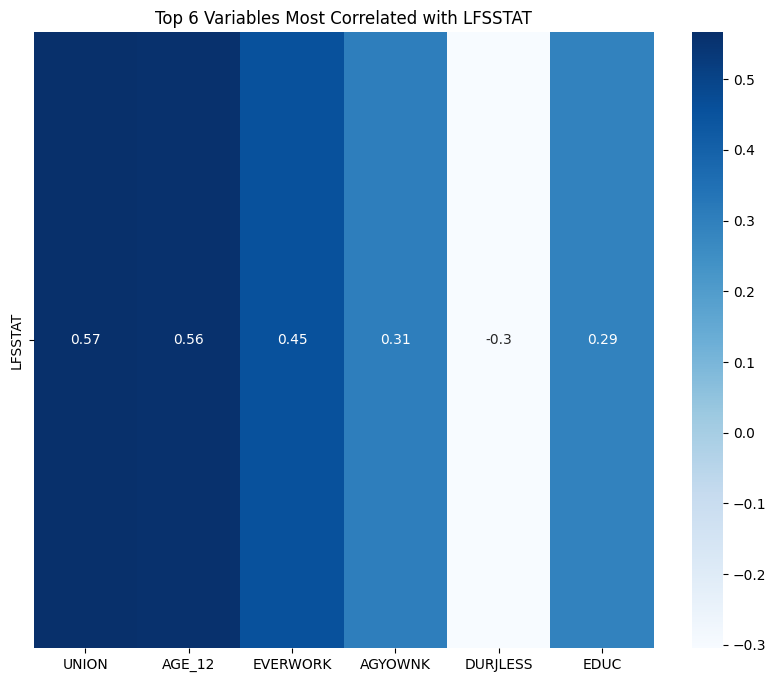

In [ ]:
# I want to see, before proceeding, which vars correlate the most with my var of interest LFSSTAT
# I take account for the fact that some vars I have are continious and others are cathegoriecal

# Listing the variables by their type
categorical  = [ 'SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC',  'EVERWORK', 'IMMIG', 'UNION', 'SCHOOLN', 'AGYOWNK']
continuous = [
    'DURJLESS', 
    'Growth rate same period previous year, s.a. Percentage',
    'Level, rate or national currency, s.a. Ratio',
    'Level, rate or national currency, s.a. Canadian Dollar, Millions'
]


# Dictionary to store correlations
correlations = {}

# Calculating correlations
for var in categorical + continuous:
    if var != 'LFSSTAT':
        if var in categorical:
            # For binary-categorical pairs, compute Cramer's V
            contingency_table = pd.crosstab(data_knn['LFSSTAT'], data_knn[var])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            phi2 = chi2/n
            r,k = contingency_table.shape
            phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
            rcorr = r-((r-1)**2)/(n-1)
            kcorr = k-((k-1)**2)/(n-1)
            correlations[var] = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
        else:
            # For binary-continuous pairs, compute point biserial correlation coefficient
            correlations[var] = pointbiserialr(data_knn['LFSSTAT'], data_knn[var])[0]


# Sorting by absolute value
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Selecting the top 6 (a bit arbitraty, but should give the main idea)
top_6_corr = dict(sorted_corr[:6])

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(top_6_corr, index=['LFSSTAT']), annot=True, cmap='Blues')
plt.title('Top 6 Variables Most Correlated with LFSSTAT')
plt.show()

NameError: ignored

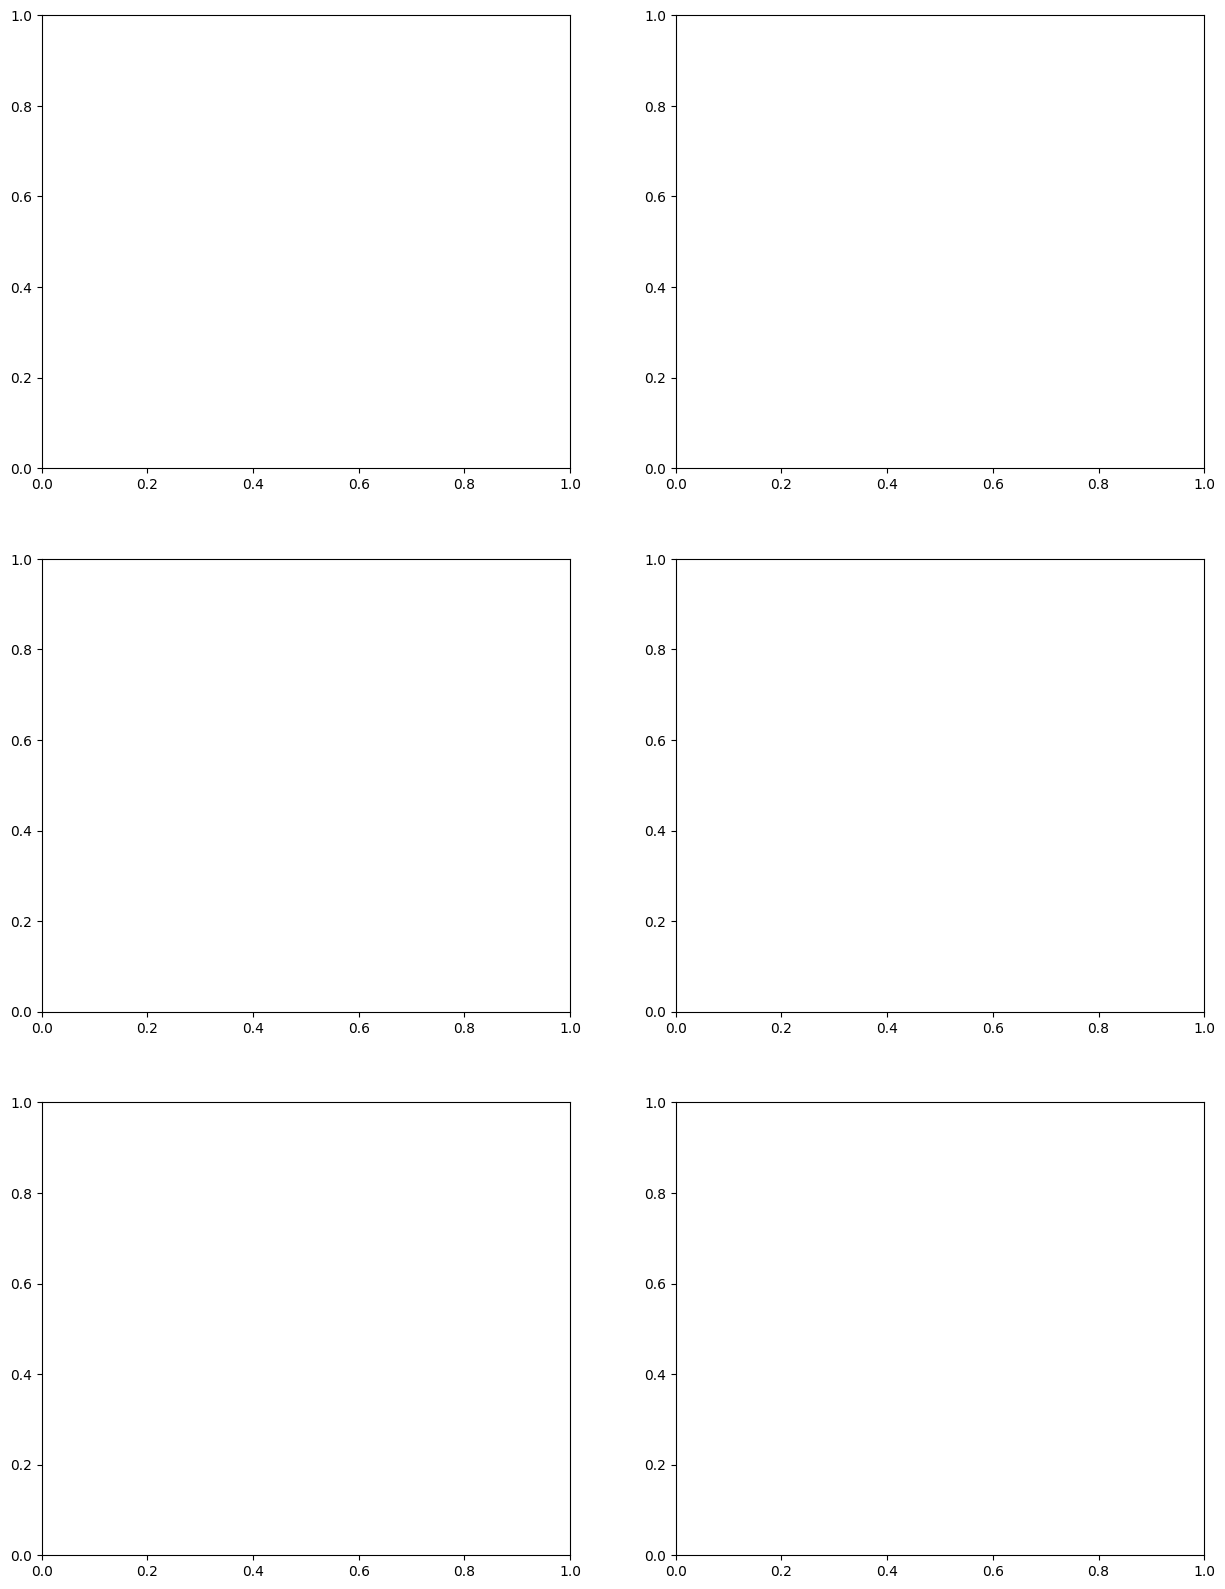

In [ ]:
# Creating a subplot
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

# Reshape axs to 1D
axs = axs.ravel()

# Generate boxplots
for i, var in enumerate(top_6_corr.keys()):
    sns.boxplot(x='LFSSTAT', y=var, data=data, palette='Blues', ax=axs[i])
    axs[i].set_title(f'Boxplot of {var} by LFSSTAT')

# Delete any unused subplots
if len(top_6_corr.keys()) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


In [ ]:
# I want to see, before proceeding, which vars correlate the most with my var of interest LFSSTAT
# I take account for the fact that some vars I have are continious and others are cathegoriecal

# Listing the variables by their type
categorical  = [ 'SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC',  'EVERWORK', 'IMMIG', 'UNION', 'SCHOOLN', 'AGYOWNK']
continuous = [
    'DURJLESS', 
    'Growth rate same period previous year, s.a. Percentage',
    'Level, rate or national currency, s.a. Ratio',
    'Level, rate or national currency, s.a. Canadian Dollar, Millions'
]


# Dictionary to store correlations
correlations = {}

# Calculating correlations
for var in categorical + continuous:
    if var != 'LFSSTAT':
        if var in categorical:
            # For binary-categorical pairs, compute Cramer's V
            contingency_table = pd.crosstab(data_mean['LFSSTAT'], data_mean[var])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            phi2 = chi2/n
            r,k = contingency_table.shape
            phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
            rcorr = r-((r-1)**2)/(n-1)
            kcorr = k-((k-1)**2)/(n-1)
            correlations[var] = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
        else:
            # For binary-continuous pairs, compute point biserial correlation coefficient
            correlations[var] = pointbiserialr(data_mean['LFSSTAT'], data_mean[var])[0]


# Sorting by absolute value
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Selecting the top 6 (a bit arbitraty, but should give the main idea)
top_6_corr = dict(sorted_corr[:6])

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(top_6_corr, index=['LFSSTAT']), annot=True, cmap='Blues')
plt.title('Top 6 Variables Most Correlated with LFSSTAT')
plt.show()

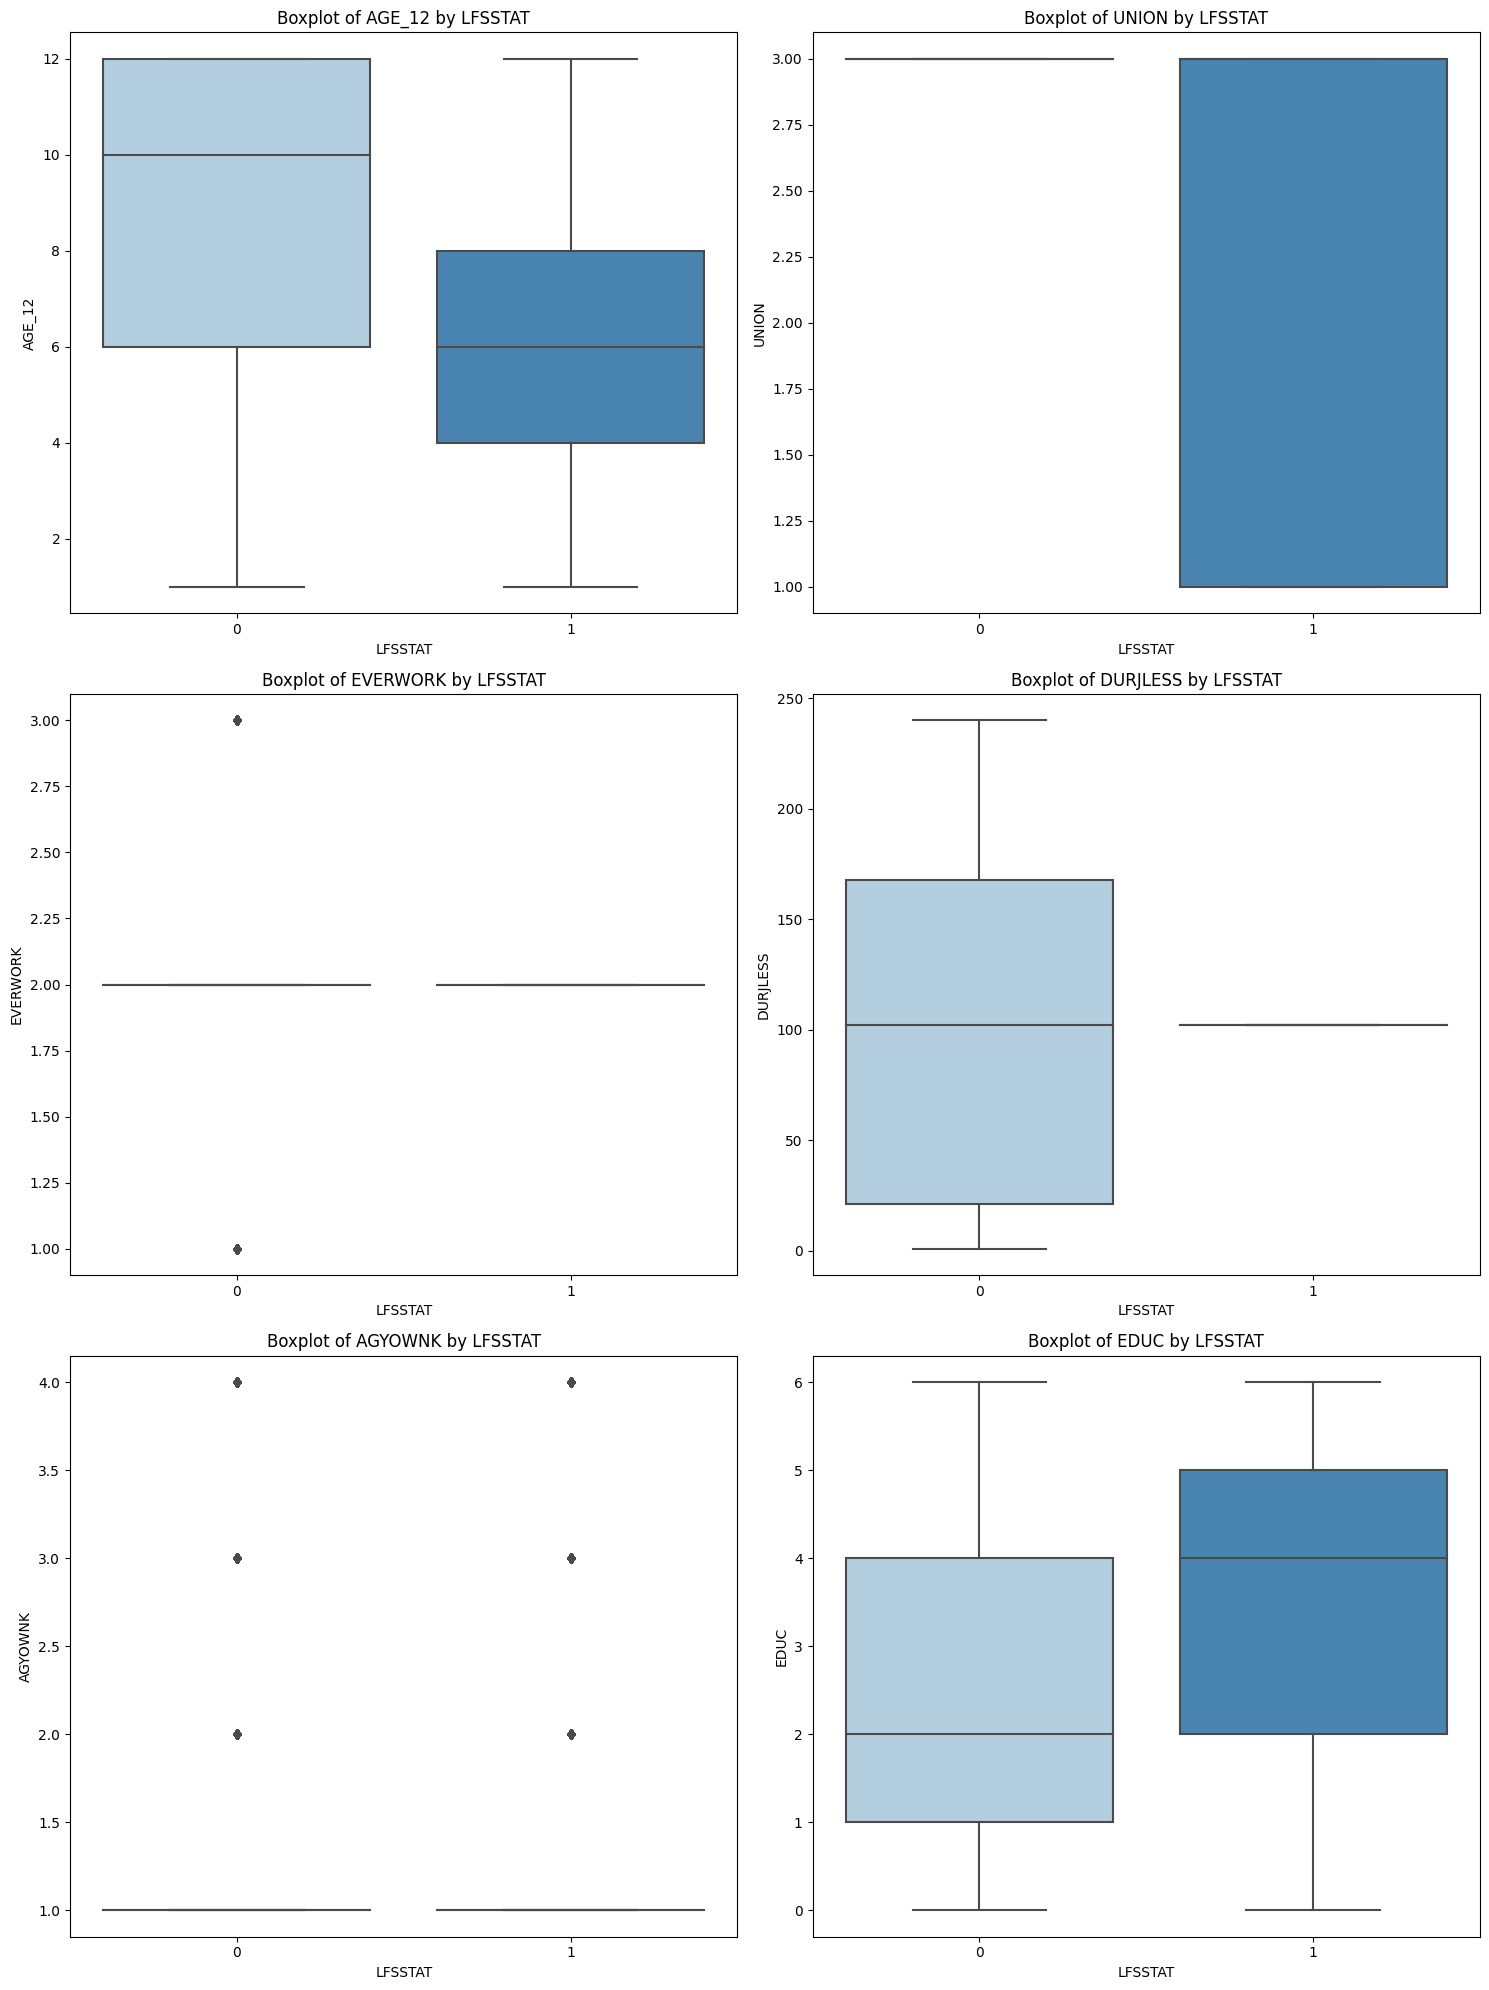

In [ ]:
# Creating a subplot
fig, axs = plt.subplots(3, 2, figsize=(15, 20))

# Reshape axs to 1D
axs = axs.ravel()

# Generate boxplots
for i, var in enumerate(top_6_corr.keys()):
    sns.boxplot(x='LFSSTAT', y=var, data=data_mean, palette='Blues', ax=axs[i])
    axs[i].set_title(f'Boxplot of {var} by LFSSTAT')

# Delete any unused subplots
if len(top_6_corr.keys()) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()

1.4. Types of data, hot ecoding and etc. 

In [ ]:
# Checking the cathegorical vars, and wheather thay have been imputed correctly and the format and stucture of them is still intact 
def print_unique_counts(data_dict, columns):
    """
    Counts and prints the unique values in specified columns of a DataFrame.
    
    Parameters:
    - data_dict: dictionary of pandas DataFrames
    - columns: list of column names to count unique values in
    """
    for data_name, df in data_dict.items():
        print(f"Dataset: {data_name}")
        for column in columns:
            counts = df[column].value_counts()
            print(f"Unique value counts in '{column}':\n{counts}\n")

# Listing of columns to count unique values in
columns_to_count = [ 'SURVMNTH', 'LFSSTAT', 'PROV', 'AGE_12', 'SEX', 'MARSTAT', 'EDUC',  'EVERWORK', 'IMMIG', 'UNION', 'SCHOOLN', 'AGYOWNK']

# Calling the function
print_unique_counts(data_dict, columns_to_count)


Dataset: KNN Imputed
Unique value counts in 'SURVMNTH':
6     20113
5     19954
4     19764
11    19528
10    19490
9     19425
7     19383
8     19342
12    19274
2     15291
1     15287
3     14940
Name: SURVMNTH, dtype: int64

Unique value counts in 'LFSSTAT':
1    130868
0     90923
Name: LFSSTAT, dtype: int64

Unique value counts in 'PROV':
35    60764
24    38930
59    26315
48    23001
46    19992
47    16016
12    11603
13    11431
10     7910
11     5829
Name: PROV, dtype: int64

Unique value counts in 'AGE_12':
12    33230
9     20754
10    20081
8     18654
11    17015
5     16988
7     16971
4     16808
6     16656
3     15488
1     14932
2     14214
Name: AGE_12, dtype: int64

Unique value counts in 'SEX':
2    113850
1    107941
Name: SEX, dtype: int64

Unique value counts in 'MARSTAT':
1    107413
6     58140
2     27200
3     11953
5     11438
4      5647
Name: MARSTAT, dtype: int64

Unique value counts in 'EDUC':
4    75399
2    45669
5    32684
1    27601
6    15117
3

In [ ]:
# Performing one-hot encoding for each dataset
columns_to_encode = ['SURVMNTH', 'PROV', 'AGE_12', 'MARSTAT', 'EDUC', 'EVERWORK', 'IMMIG', 'AGYOWNK']

for data_name in data_dict.keys():
    data_dict[data_name] = pd.get_dummies(data_dict[data_name], columns=columns_to_encode)


In [ ]:
# Other vars I want to transform into binary, where I think I will not results in the loss of information 
# Define a function to recategorize variables
def recategorize(val):
    if val == 1 or val == 2:
        return val
    else:
        return 2

# Define the columns to recategorize
columns_to_recategorize = ['UNION', 'SCHOOLN']

# Apply the function to each dataset in the dictionary for each specified column
for data_name in data_dict.keys():
    for column in columns_to_recategorize:
        data_dict[data_name][column] = data_dict[data_name][column].apply(recategorize)


In [ ]:
# Transforming the dependant var inot teh correct form
for name, dataset in data_dict.items():
    dataset['LFSSTAT'] = dataset['LFSSTAT'].astype(int)

1.3. Balancing the data

In [ ]:
# I am checking how ballanced is the depandant var LFSSTAT
for name, dataset in data_dict.items():
    print(f"Dataset: {name}")
    print(dataset['LFSSTAT'].value_counts(normalize=True))  # Normalize=True to get proportions instead of count

Dataset: KNN Imputed
1    0.590051
0    0.409949
Name: LFSSTAT, dtype: float64
Dataset: Mean Imputed
1    0.590051
0    0.409949
Name: LFSSTAT, dtype: float64


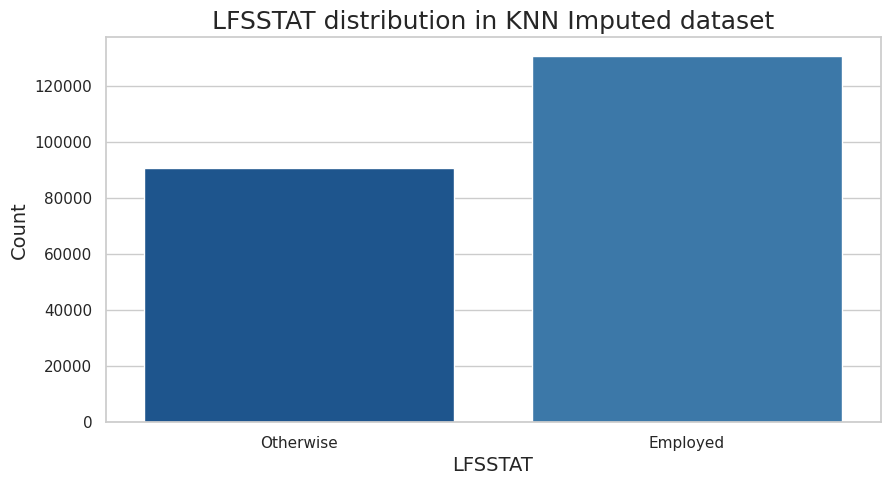

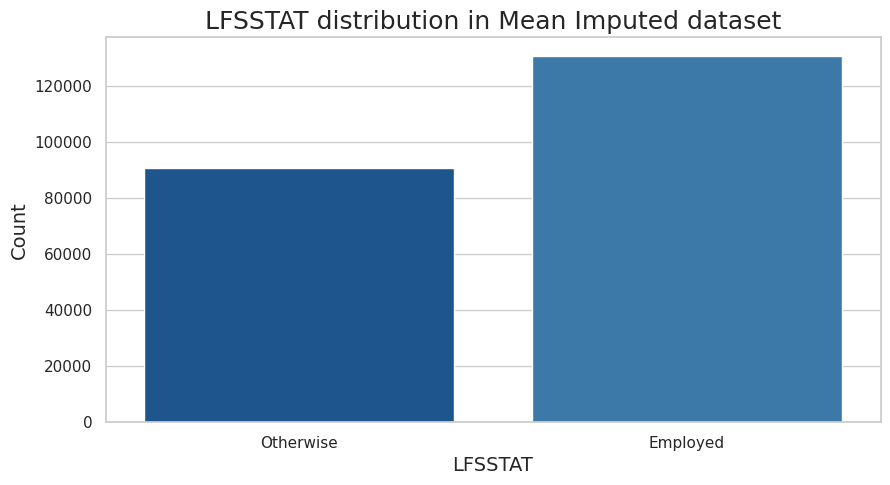

In [ ]:
# Plotting the balance of the depandant var LFSSTAT for better overviw (+ to add later inot the report)
# Set the Seaborn theme
sns.set_theme(style="whitegrid")

# Use palette for blue colors
blue_palette = sns.color_palette("Blues_r")

for name, dataset in data_dict.items():
    plt.figure(figsize=(10, 5))
    
    # Use seaborn countplot to get blue colors and bar widths that represent counts
    sns.countplot(x="LFSSTAT", data=dataset, palette=blue_palette)
    
    plt.title(f'LFSSTAT distribution in {name} dataset', fontsize=18)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('LFSSTAT', fontsize=14)
    
    # Replacing 0 and 1 with 'Otherwise' and 'Employed' for x-axis
    plt.xticks([0, 1], ['Otherwise', 'Employed'])
    
    plt.show()

#Step 2: Building Up the Models + Traning + Evaluating 

2.1. Models: 
(i) LogisticRegression, 
(ii) SVC, 
(iii) DecisionTreeClassifier, 
(iv) RandomForestClassifier, 
(v) KNeighborsClassifier, 
(vi) GaussianNB, 
(vii) GradientBoostingClassifier, 
(viii) XGBClassifier


Processing KNN Imputed dataset.

Training LogisticRegression...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklea

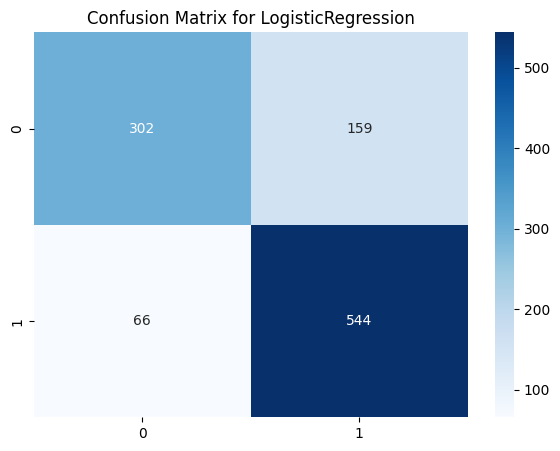

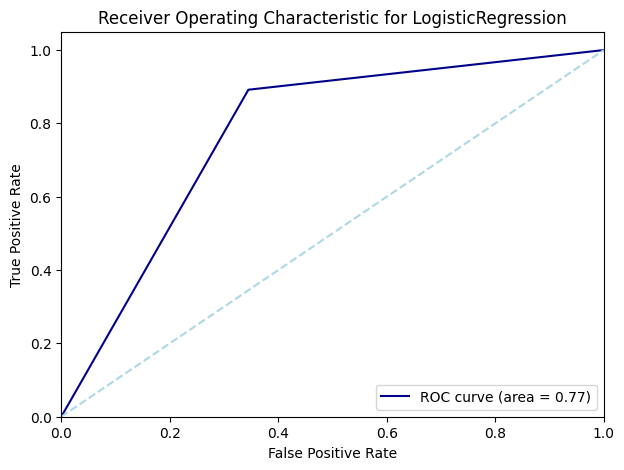

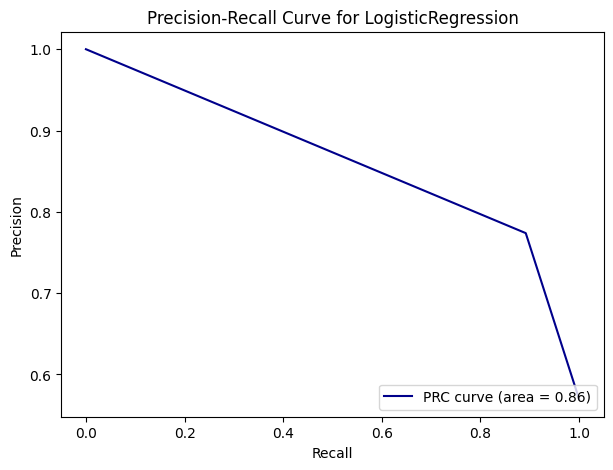


Training DecisionTreeClassifier...


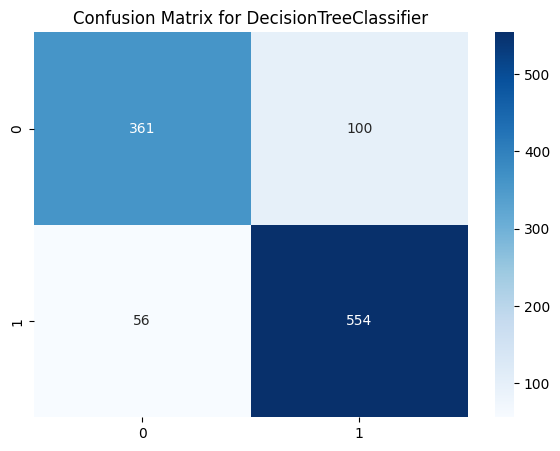

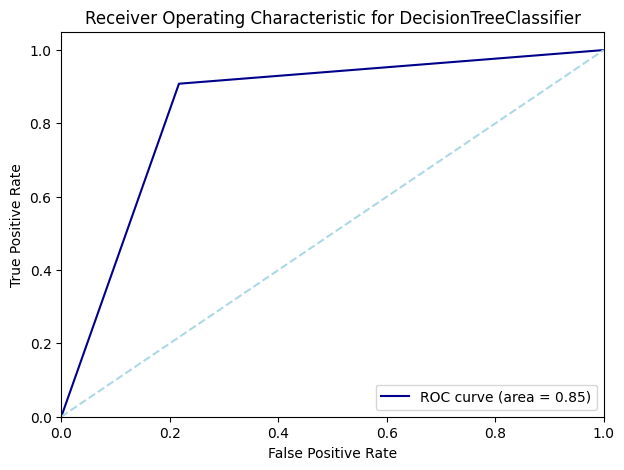

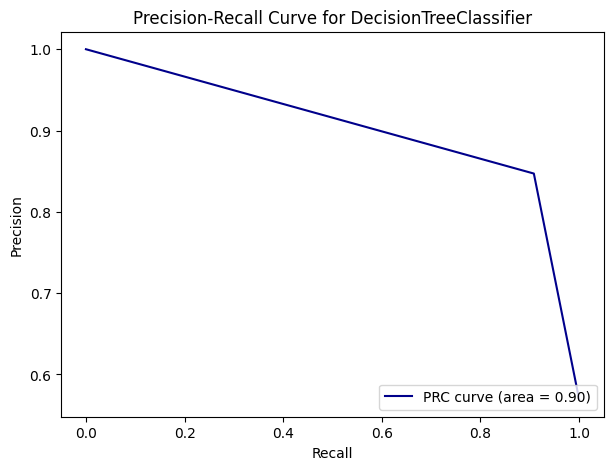


Training RandomForestClassifier...


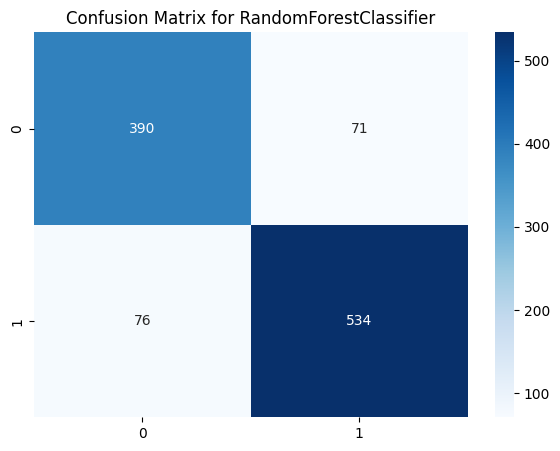

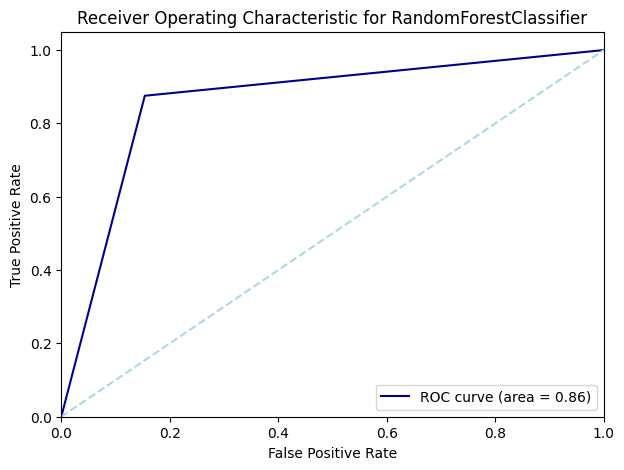

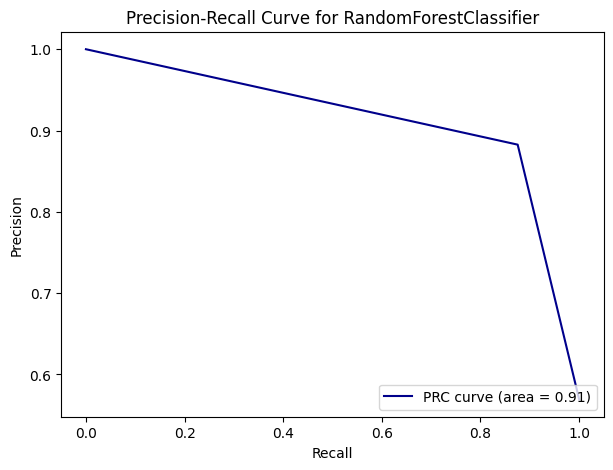


Calculating feature importances for RandomForestClassifier...


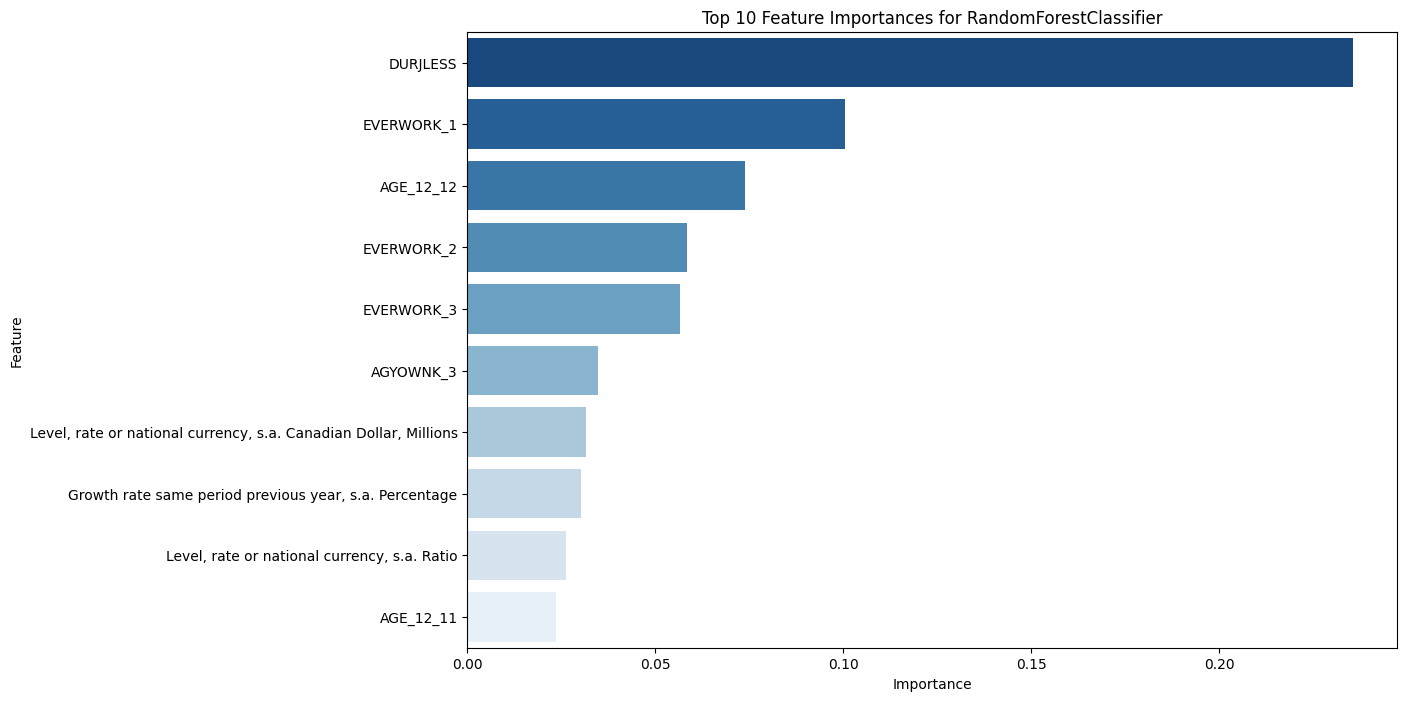


Training KNeighborsClassifier...


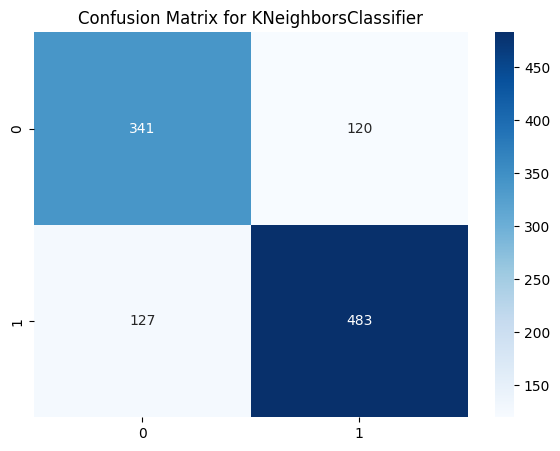

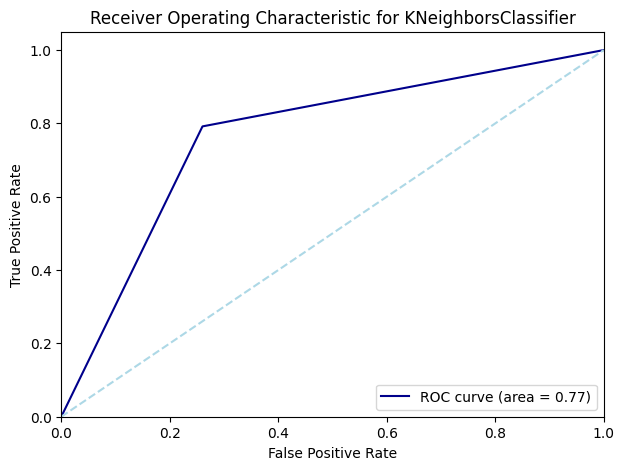

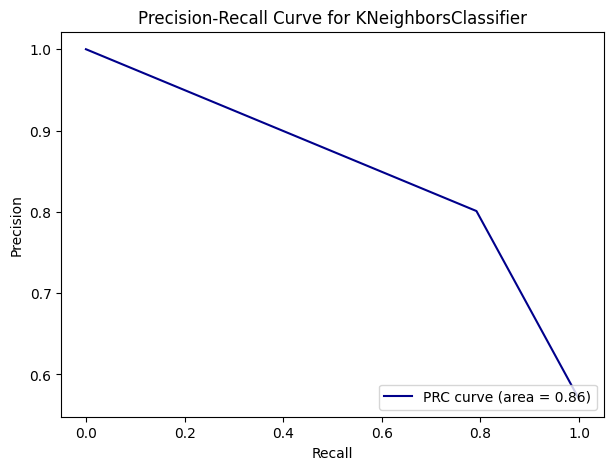


Training GaussianNB...


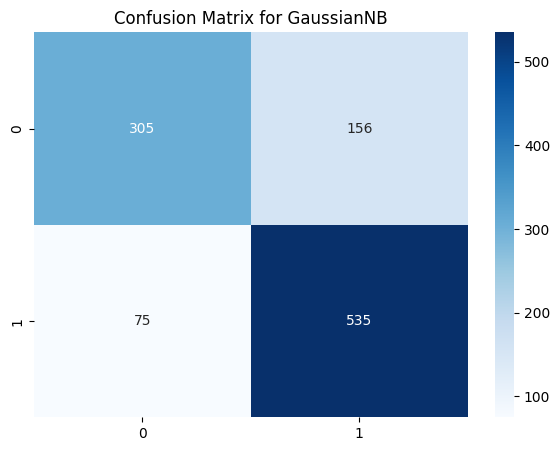

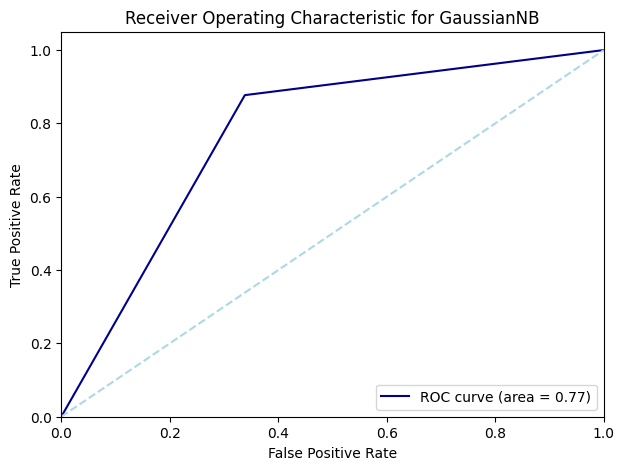

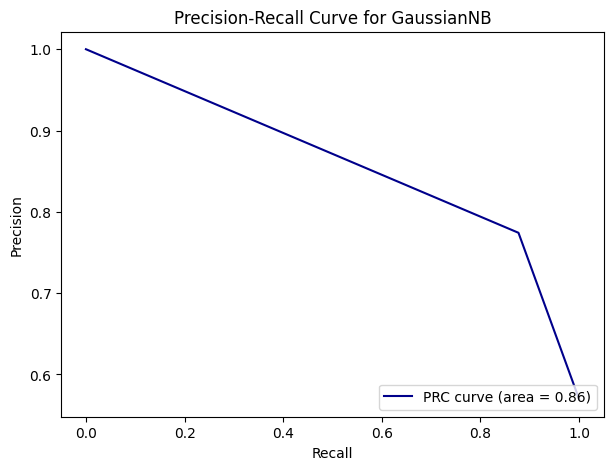


Training GradientBoostingClassifier...


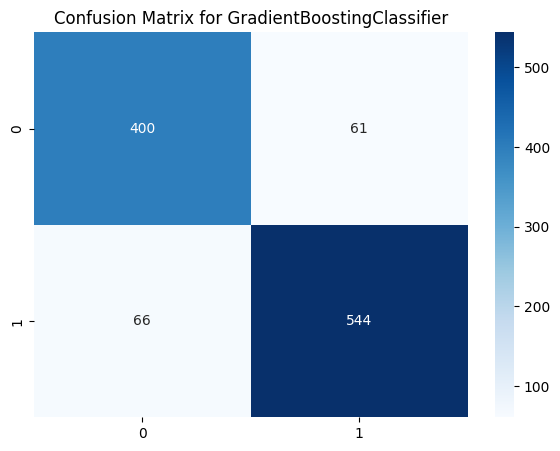

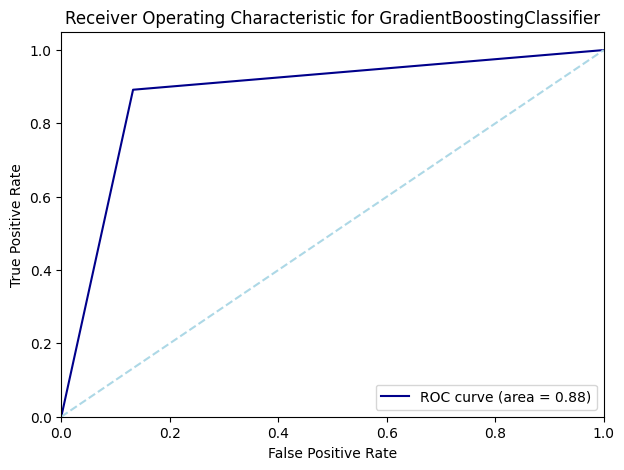

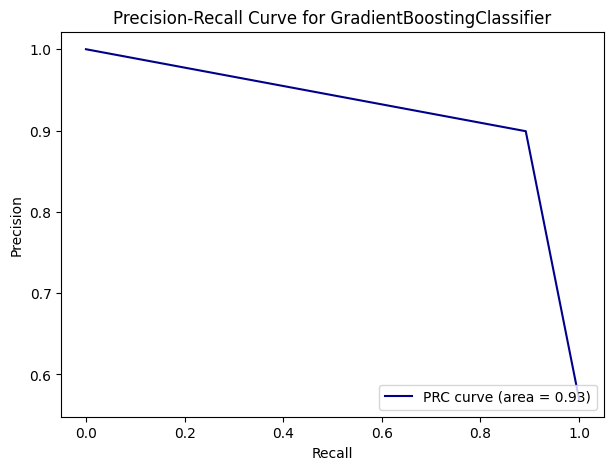


Calculating feature importances for GradientBoostingClassifier...


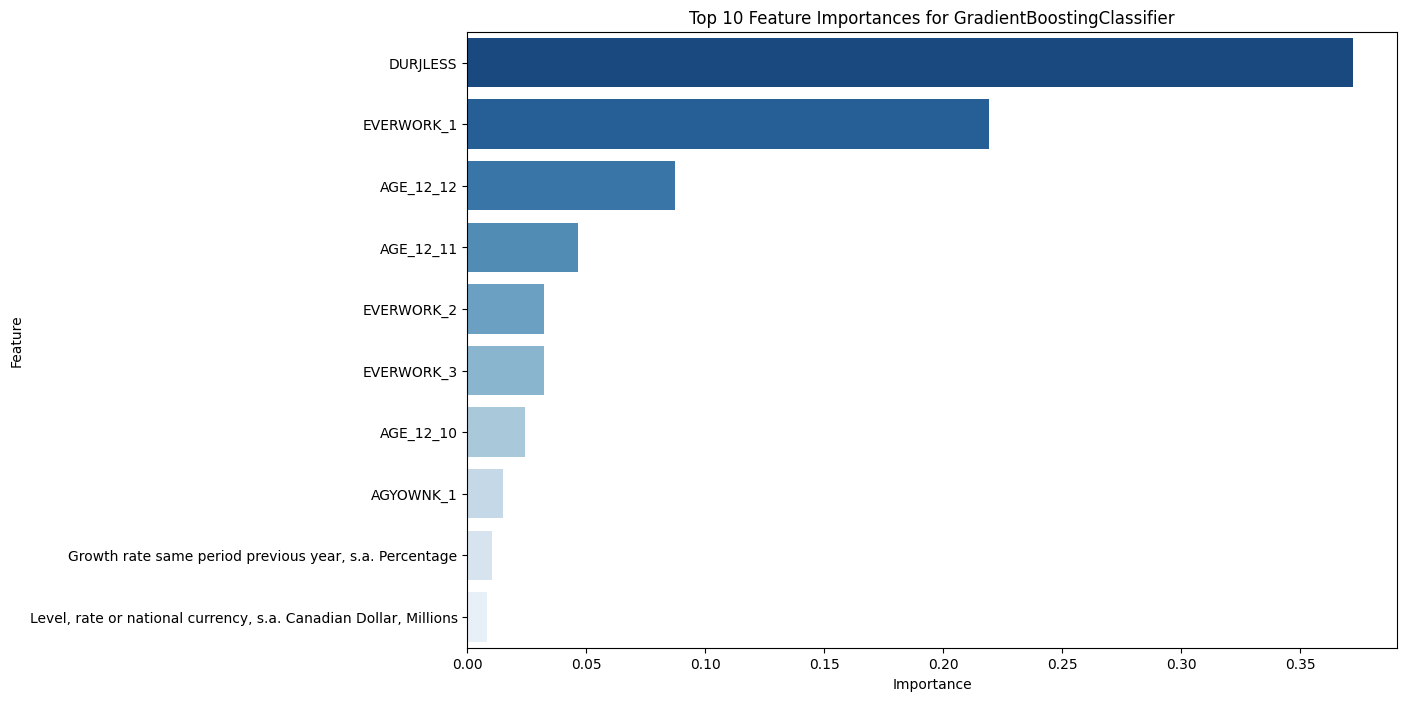


Training XGBClassifier...


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


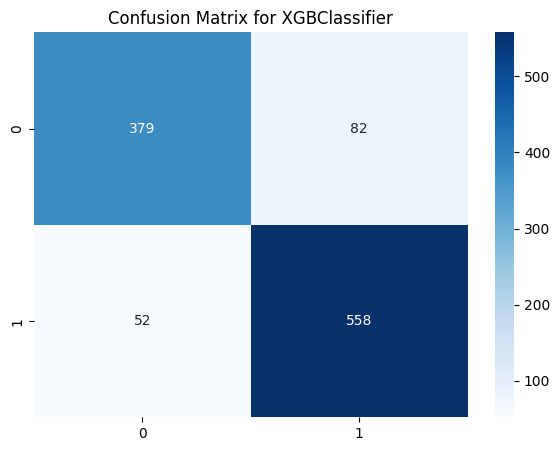

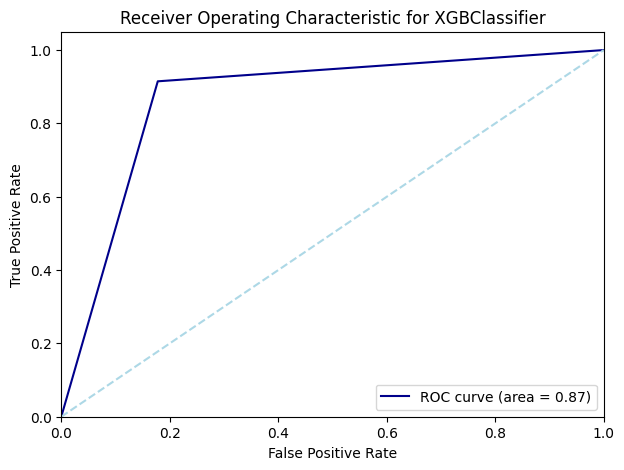

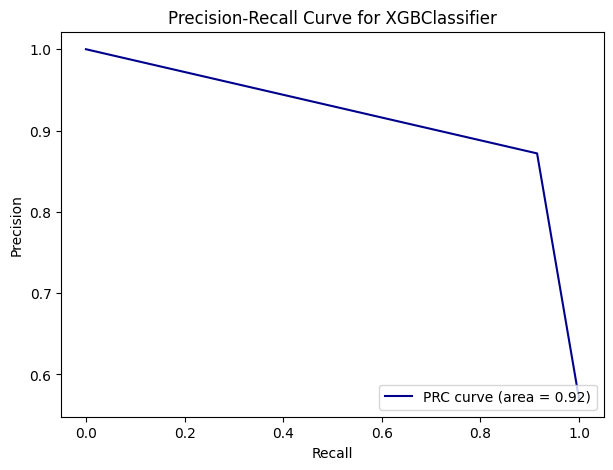


Calculating feature importances for XGBClassifier...


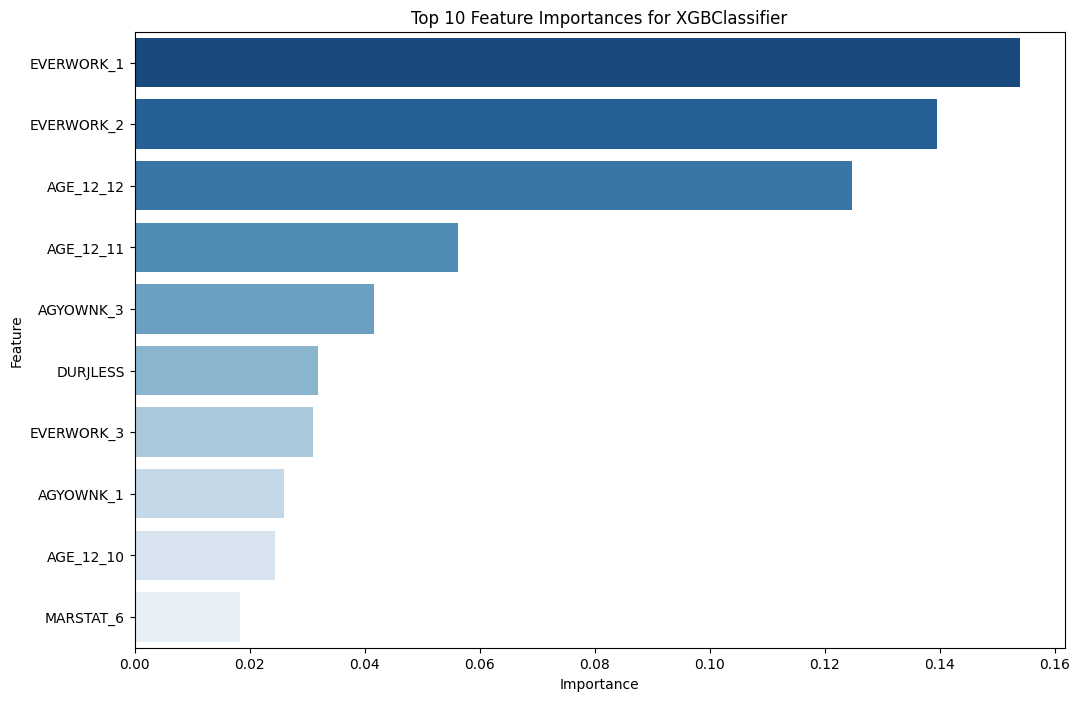

In [ ]:
# Create a dictionary for the GridSearch parameters for each algorithm
param_dict = {
    LogisticRegression: {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2', 'None'],
        'solver': ['lbfgs', 'liblinear']},

    DecisionTreeClassifier: {
        'max_depth': [3, 5, 10, 20],
        'min_samples_leaf': [2, 4, 6]},
    RandomForestClassifier: {
        'n_estimators': [10, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt']},
    KNeighborsClassifier: {
        'n_neighbors': list(range(1,30)),
        'weights': ['uniform', 'distance']},
    GaussianNB: {},
    GradientBoostingClassifier: {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 10]
    },
    XGBClassifier: {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 1],
        'max_depth': [3, 5, 10],
        'use_label_encoder':[False]
    },
}

# Models to train
models = [
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    KNeighborsClassifier,
    GaussianNB,
    GradientBoostingClassifier,
    XGBClassifier,
]

# Models to calculate feature importances for
importance_models = [
    GradientBoostingClassifier,
    XGBClassifier,
    RandomForestClassifier,
]

# Initialize oversampler and results
oversample = RandomUnderSampler()
results = {}

# Splitting, normalizing and training on each dataset
for name, data in data_dict.items():
    print(f"\nProcessing {name} dataset.")
    
    # Initialize dataset results
    results[name] = {}

    # Separating features and target
    X = data.drop(['LFSSTAT', 'Date'], axis=1)  # Remove 'Date' from feature set
    y = data['LFSSTAT']

    # Create masks for the split
    train_mask =  (data['Date'].dt.year < 2020)
    test_mask = data['Date'].dt.year >= 2020

    # Splitting based on masks
    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]
    
    # Balancing
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
    # Normalizing
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Model training
for model in models:
    if model.__name__ not in results[name]:  # if the model's results aren't in the dictionary
        print(f"\nTraining {model.__name__}...")
        classifier = model()
        grid_search = GridSearchCV(estimator=classifier, param_grid=param_dict[model], cv=5)
        grid_search.fit(X_train, y_train)
        
        # Predicting
        y_pred = grid_search.predict(X_test)
        
        # Store metrics
        results[name][model.__name__] = {
            'Best Params': grid_search.best_params_,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1-score': f1_score(y_test, y_pred, average='weighted'),
            'AUC-ROC': roc_auc_score(y_test, y_pred)
        }

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(7,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model.__name__}')
        plt.show()

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(7,5))
        plt.plot(fpr, tpr, color='darkblue', label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='lightblue', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for {model.__name__}')
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        plt.figure(figsize=(7,5))
        plt.plot(recall, precision, label=f'PRC curve (area = {auc_score:0.2f})', color='darkblue')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {model.__name__}')
        plt.legend(loc="lower right")
        plt.show()

        # Calculate feature importance if the model is in 'importance_models'
        if model in importance_models:
            print(f"\nCalculating feature importances for {model.__name__}...")
            best_model = grid_search.best_estimator_
            importances = best_model.feature_importances_
            feature_importances = pd.DataFrame({
                'Feature': X.columns,
                'Importance': importances,
            }).sort_values(by='Importance', ascending=False)

            plt.figure(figsize=(12, 8))
            sns.barplot(data=feature_importances[:10], x='Importance', y='Feature', palette='Blues_r')
            plt.title(f'Top 10 Feature Importances for {model.__name__}')
            plt.show()


In [ ]:
for dataset, model_metrics in results.items():
    for model, metrics in model_metrics.items():
        print(f"Dataset: {dataset}, Model: {model}, Best Parameters: {metrics['Best Params']}")


Dataset: KNN Imputed, Model: LogisticRegression, Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Dataset: KNN Imputed, Model: DecisionTreeClassifier, Best Parameters: {'max_depth': 10, 'min_samples_leaf': 6}
Dataset: KNN Imputed, Model: RandomForestClassifier, Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200}
Dataset: KNN Imputed, Model: KNeighborsClassifier, Best Parameters: {'n_neighbors': 18, 'weights': 'distance'}
Dataset: KNN Imputed, Model: GaussianNB, Best Parameters: {}
Dataset: KNN Imputed, Model: GradientBoostingClassifier, Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Dataset: KNN Imputed, Model: XGBClassifier, Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'use_label_encoder': False}


In [ ]:
# Now, let's create a DataFrame for each model's metrics:
all_results_df = pd.DataFrame()

for dataset_name, dataset_results in results.items():
    for model_name, model_results in dataset_results.items():
        model_results_df = pd.DataFrame(model_results, index=[0])
        model_results_df.insert(0, 'Dataset', dataset_name)
        model_results_df.insert(1, 'Model', model_name)
        all_results_df = all_results_df.append(model_results_df, ignore_index=True)

display(all_results_df)

<ipython-input-57-13bbad0e834d>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results_df = all_results_df.append(model_results_df, ignore_index=True)
<ipython-input-57-13bbad0e834d>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results_df = all_results_df.append(model_results_df, ignore_index=True)
<ipython-input-57-13bbad0e834d>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results_df = all_results_df.append(model_results_df, ignore_index=True)
<ipython-input-57-13bbad0e834d>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_results_df = all_results_df.append(model_results_df, ignore_index=True)
<ipython-input-5

,Dataset,Model,Best Params,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,Mean Imputed,LogisticRegression,NaN,0.872082,0.872792,0.872082,0.871239,0.864391
1,Mean Imputed,DecisionTreeClassifier,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
2,Mean Imputed,RandomForestClassifier,NaN,0.997199,0.997217,0.997199,0.997200,0.997541
3,Mean Imputed,KNeighborsClassifier,NaN,0.817927,0.820248,0.817927,0.818487,0.818175
4,Mean Imputed,GaussianNB,NaN,0.993464,0.993562,0.993464,0.993470,0.994262
5,Mean Imputed,GradientBoostingClassifier,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
6,Mean Imputed,XGBClassifier,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
